### Initialize notebook

In [76]:
# Torch imports
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import PIL.Image as IMG

# Other imports
import matplotlib.pyplot as plt
import numpy as np
import os
os.chdir('/home/ak/Spring2018/ature')
sep = os.sep

# Define folders (create them if needed)
Dirs = {}
Dirs['data']      = 'data'+sep+'DRIVE'+sep+'test'+sep +'patches'

# Set up execution flags
Flags = {}
Flags['useGPU'] = False

In [82]:
class DriveDataset(Dataset):
    
    ## INPUT
    # data_path should contain pickled numpy array of dimension N * (D+1)
    # Where extra one dimension stores the correct lable among (0, 1, 2, 3)
    
    ## self.labels contains one-hot encoding
    ## self.target contains true labels (single value)
    
    def __init__(self, data_path=None, height=None, width=None, transform=None):
        
        self.data = None
        self.height = height
        self.width = width
        self.transform = transform
        
        for data_file in os.listdir(data_path):
            
            data_file = os.path.join(data_path, data_file)
            print('Data file: ' + data_file)
            if self.data is None:
                self.data = np.load(data_file)
            else:
                self.data = np.concatenate((self.data, np.load(data_file)), axis=0)
    
        self.data_len = self.data.shape[0]
        
        self.labels = np.zeros((self.data_len, 4), dtype=np.long)
        self.target = self.data[:, self.height * self.width] 
        self.labels[range(self.data_len), self.target] = 1
        
        self.data = self.data[:,0:self.height * self.width]
        self.target = np.array(self.target, np.long)
        
        
    def __getitem__(self, index):
        
        a_data = self.data[index]
        img_arr = a_data.reshape(self.height, self.width)
        img = IMG.fromarray(img_arr)
        
        if self.transform is not None:
            img_tensor = self.transform(img)
#             
#         return (img_tensor, torch.LongTensor(self.target[index]))
        return (img_tensor, torch.from_numpy(self.labels[index])) 
    
    def __len__(self):
        return self.data_len

In [78]:
transform = transforms.Compose([transforms.ToTensor()])

data_path = Dirs['data']

trainset = DriveDataset(data_path=data_path, height=51, width=51, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2,
                                          shuffle=True, num_workers=1)


# testset = torchvision.datasets.CIFAR10(root=Dirs['data'], train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=4,
#                                          shuffle=False, num_workers=2)

classes = ('white', 'green', 'black', 'red')

Data file: data/DRIVE/test/patches/16_test.npy


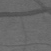

In [86]:
IMG.fromarray(trainset.data[10].reshape(51,51))

### Define the network

In [79]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

net = Net()

# Send network to the GPU, if requested
if Flags['useGPU']:
    net.cuda()

# Define loss criterion
# criterion = nn.L1Loss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


### Train the network

In [81]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        if Flags['useGPU']:
            # Wrap them in Variable (CPU version)
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())                
        else:                
            # Wrap them in Variable (GPU version)
            inputs, labels = Variable(inputs), Variable(labels)
#         print(inputs, labels)
#         break

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


RuntimeError: multi-target not supported at /pytorch/torch/lib/THNN/generic/ClassNLLCriterion.c:22

### Test the network

In [ ]:
correct = 0
total = 0
for data in testloader:
    images, labels = data        
    if Flags['useGPU']:
        images = images.cuda()
        labels = labels.cuda()

    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


### Check per-class performance

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    if Flags['useGPU']:
        images = images.cuda()
        labels = labels.cuda()

    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
